## Import Relevant Libraries

In [ ]:
!pip install darts yfinance

In [ ]:
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import RNNModel
from darts.metrics import mape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models import forecasting
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller


import yfinance as yf

## Data Pre-Processing

In [ ]:
#Getting date from one year ago
one_year_ago = datetime.now() - relativedelta(years=1)
one_year_ago = one_year_ago.strftime("%Y-%m-%d")

#Getting date today
today = datetime.now()
today = today.strftime("%Y-%m-%d")

#Adding one day to the date one year ago
one_year_ago_plus_one = datetime.now() - relativedelta(years=1) + timedelta(days=1)
one_year_ago_plus_one = one_year_ago_plus_one.strftime("%Y-%m-%d")
four_years_ago = datetime.now() - relativedelta(years=4)
four_years_ago = four_years_ago.strftime("%Y-%m-%d")
print(four_years_ago)
print(today)
#Accessing YFinance
ticker= yf.Ticker("adbe")

#Getting pandas dataframe of stock data from one year ago
df = ticker.history(start=one_year_ago, end=today, interval="1d")
print(df)
idx = pd.date_range(start=one_year_ago_plus_one, end=today)
# print(idx)



#Making index into Datetime index
df.index = pd.DatetimeIndex(df.index)
df.index = df.index.tz_localize(None)

#Reindexing dataframe to fill in missing dates due to stock market closing on weekends
df = df.reindex(idx, method = 'pad')


print(df)
print(len(df))



In [ ]:
#Put dataframe into a Darts "Timeseries" object so that data can be fed into a Darts forecasting model. For more information on Timeseries objects, please look here: https://unit8co.github.io/darts/generated_api/darts.timeseries.html
series = TimeSeries.from_dataframe(df)

#Drop all columns besides "Close" Column
#adj_series = series.drop_columns(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])
adj_series = series.drop_columns(['Open','High','Low','Volume', 'Dividends', 'Stock Splits'])
print(adj_series[-1])

In [ ]:

#Divide dataset into training and validation/testing sets. "Split_after" function is a method of a Darts Timeseries object. https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.split_after
training, validation = adj_series.split_after(0.8)

#Plot training and testing data
training.plot(label='training')
validation.plot(label='validation')
plt.legend();
plt.title("Training and Validation Plots")

In [ ]:
#Transform training set, validation set, and entire series to values between 0 and 1.
transformer = Scaler()
train_transformed = transformer.fit_transform(training)
val_transformed = transformer.transform(validation)
# series_transformed = transformer.transform(adj_series)
# print(train_transformed)
# print(val_transformed)
# print(series_transformed)

## Construct LSTM Model in Darts

In [ ]:
#Define LSTM Model
my_model = RNNModel(
    model="LSTM",
    n_rnn_layers = 4, # Number of LSTM layers
    hidden_dim=10,
    dropout=0.06,
    batch_size=31,
    n_epochs=50,
    optimizer_kwargs={"lr": 1e-3}, #learning rate
    model_name="Stock_Forecast",
    log_tensorboard=False,
    training_length=30,
    input_chunk_length=14,
    force_reset=True,
    save_checkpoints=True,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    },
)

#Fit model on training data
my_model.fit(train_transformed)

#Predict values
pred = my_model.predict(n=len(val_transformed))

## Evaluating Results

MAPE = 22.34%


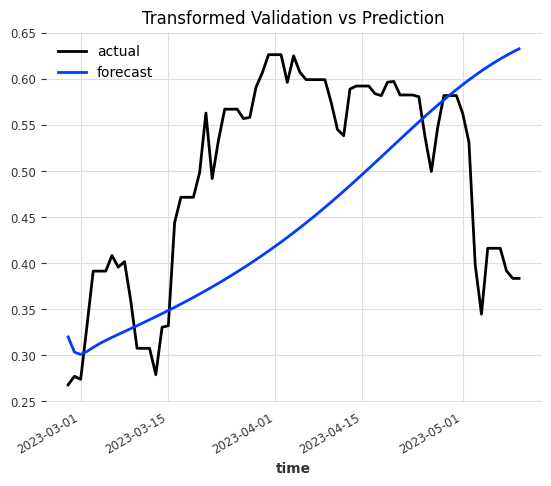

In [ ]:
#Plot transformed validation set vs prediction
val_transformed.plot(label='actual')
pred.plot(label='forecast')
plt.legend();
plt.title("Transformed Validation vs Prediction")
print('MAPE = {:.2f}%'.format(mape(val_transformed, pred)))


<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[386.48201329]]])
Coordinates:
  * time       (time) datetime64[ns] 2023-05-10
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
386.48201328989774
MAPE = 5.25%


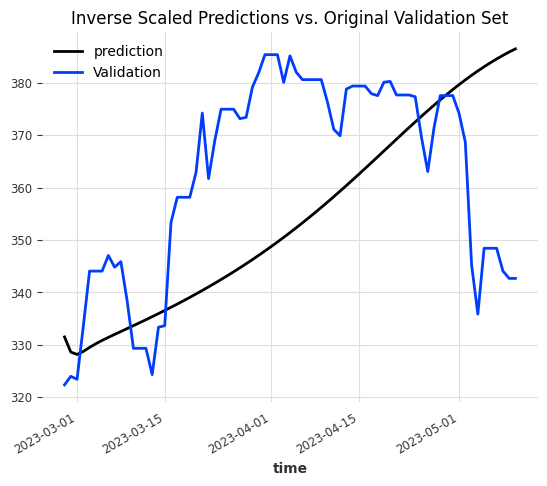

In [ ]:
#Perform inverse scaling on prediction
inverse_scaler_pred = transformer.inverse_transform(pred)
print(inverse_scaler_pred[-1])
# reverse_pred = TimeSeries.pd_dataframe(inverse_scaler_pred)
# print(reverse_pred['Close'][-1])

last_value_from_pred = TimeSeries.pd_dataframe(inverse_scaler_pred)["Close"][-1]
print(last_value_from_pred)
#Plot inverse scaled predictions with validation
inverse_scaler_pred.plot(label='prediction')
validation.plot(label='Validation')
plt.legend();
plt.title("Inverse Scaled Predictions vs. Original Validation Set")
print('MAPE = {:.2f}%'.format(mape(validation, inverse_scaler_pred)))

MAPE = 5.25%


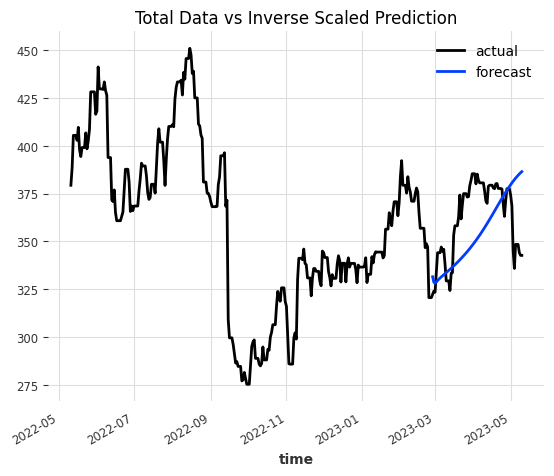

In [ ]:
#Plot total data vs prediction
adj_series.plot(label='actual')
inverse_scaler_pred.plot(label='forecast')
plt.legend();
plt.title("Total Data vs Inverse Scaled Prediction")
print('MAPE = {:.2f}%'.format(mape(adj_series, inverse_scaler_pred)))